# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [4]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
# Import models you're considering

from Data.load_data import get_energy_data

Importing plotly failed. Interactive plots will not work.


## Model Selection

### Prophet
> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

> Prophet is open source software released by Facebook's Core Data Science team. It is available for download on CRAN and PyPI.

https://facebook.github.io/prophet/

A model description can be found in this [paper](https://peerj.com/preprints/3190/).

Our data consists of different types of saisonality (seasons, weekend/working day and day/night) such that it should work very well with prophet.

Assumptions:
- We assume that saisonality is additive, i.e. saisonality does not grow with the trend: [docs multiplicative_seasonality](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html)
- We start with Prophet's default fitting of saisonalities (yearly, weekly, daily): [docs custom seasonalities](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities)
- We use the default holidays for Germany from Prophet
- We ignore temperature in the first step as adding an additional regressor to the prophet model requires the regressor to be known in the past and also the future. This means this data comes from another source (could also be predicted values from another model): [docs additional regressors](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors)


## Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]


In [5]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = get_energy_data()

df_prophet = pd.DataFrame()
df_prophet['ds'] = list(map(lambda x: x.replace(tzinfo=None), df.index))
df_prophet['y'] = df['Load'].reset_index(inplace=False)['Load']

# Split the dataset
df_train_prophet, df_test_prophet = train_test_split(df_prophet, test_size=0.2, shuffle=False)


## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


In [ ]:
# Implement hyperparameter tuning
# Example using GridSearchCV with a DecisionTreeClassifier
# param_grid = {'max_depth': [2, 4, 6, 8]}
# grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
# grid_search.fit(X_train, y_train)


## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [6]:
# Add additonal holidays
# Fronleichnam: 15.06.2017, 31.05.2018, 20.6.2019
# Allerheiligen 01.11.XXXX
additional_holidays_no_window = pd.DataFrame({
  'holiday': 'additional_german_holidays',
  'ds': pd.to_datetime([
      '2017-12-31', '2018-12-31', '2019-12-31',
      '2017-11-01', '2018-11-01', '2019-11-01',
      '2017-06-15', '2018-05-31', '2019-06-20',
      ]),
  'lower_window': 0,
  'upper_window': 0,
})

# Make week between Christmas and new year a special week
additional_holidays_upper_window = pd.DataFrame({
  'holiday': 'additional_german_holidays',
  'ds': pd.to_datetime([
      '2017-12-24', '2018-12-24', '2019-12-24',
      ]),
  'lower_window': -1,
  'upper_window': 7,
})

holidays=pd.concat([additional_holidays_no_window, additional_holidays_upper_window])

prophet2 = Prophet(changepoint_prior_scale=0.001, holidays=holidays, scaling='minmax') # making the trend less flexible or flat with growth='flat'
prophet2.add_country_holidays(country_name='DE')
prophet2.fit(df_train_prophet)
future2 = prophet2.make_future_dataframe(periods=df_test_prophet.shape[0], freq='H')
forecast2 = prophet2.predict(future2)


21:57:33 - cmdstanpy - INFO - Chain [1] start processing
21:57:35 - cmdstanpy - INFO - Chain [1] done processing


## Graphics

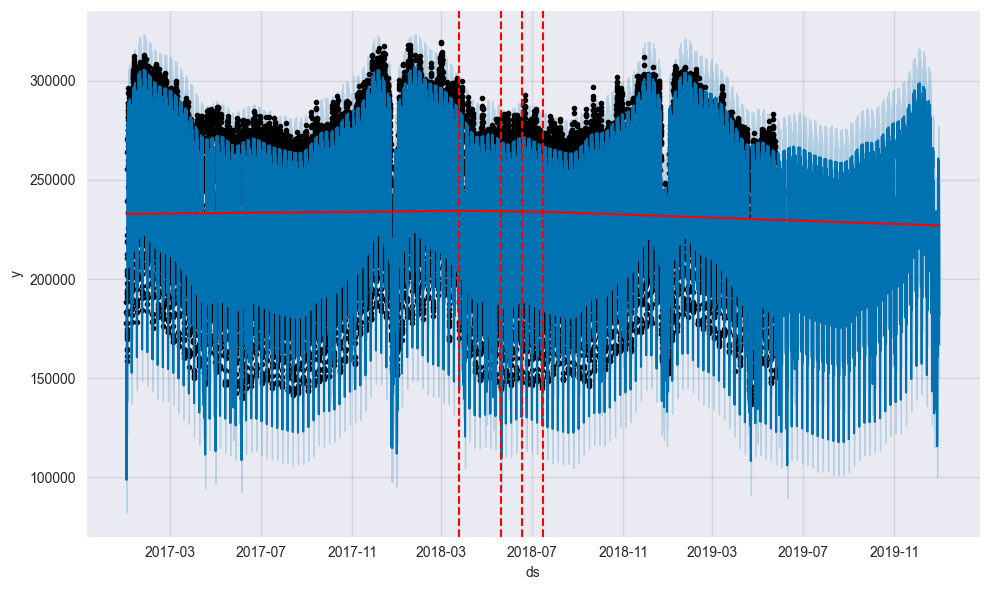

In [7]:
fig1 = prophet2.plot(forecast2)
a = add_changepoints_to_plot(fig1.gca(), prophet2, forecast2)

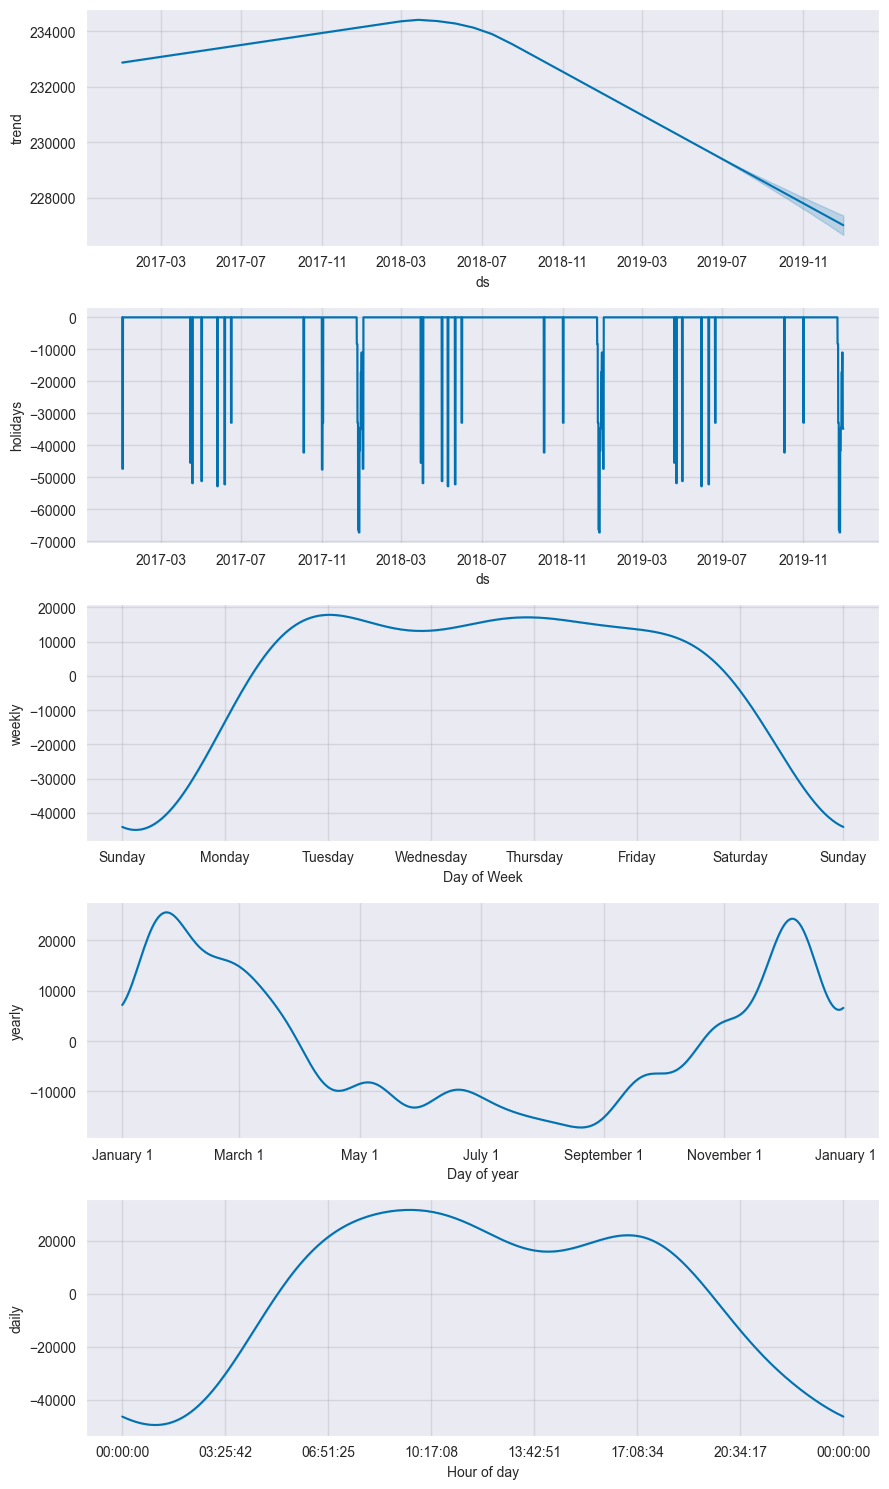

In [8]:
fig2 = prophet2.plot_components(forecast2)

<Axes: xlabel='ds'>

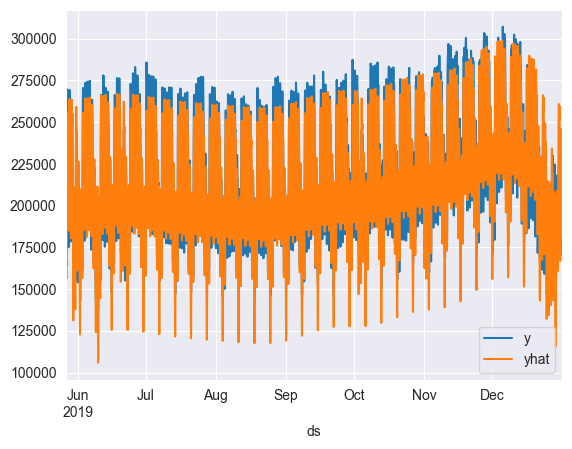

In [9]:
df_pred_prophet2 = pd.DataFrame()
df_pred_prophet2['y'] = df_test_prophet['y']
df_pred_prophet2['yhat'] = forecast2['yhat'].iloc[int(df_train_prophet.shape[0]):]
df_pred_prophet2.index = df_test_prophet['ds']
df_pred_prophet2[['y', 'yhat']].plot()

<Axes: xlabel='ds'>

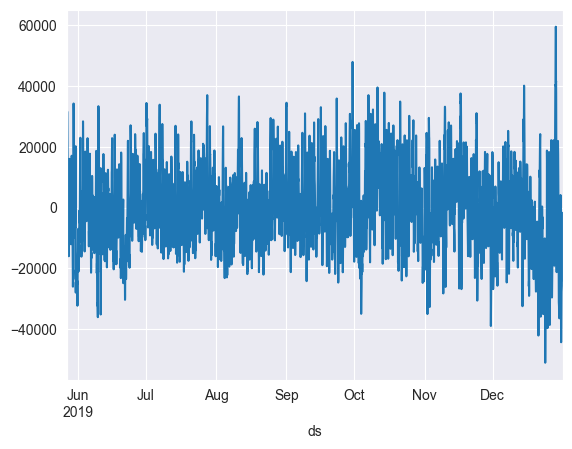

In [10]:
df_pred_prophet2['residuals'] = df_pred_prophet2['y'] - df_pred_prophet2['yhat']
df_pred_prophet2['residuals'].plot()

<Axes: >

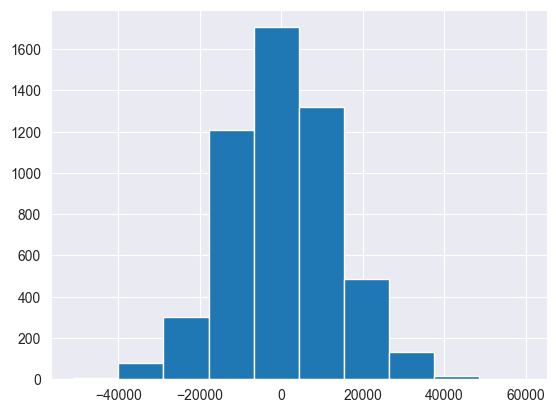

In [11]:
df_pred_prophet2['residuals'].hist()

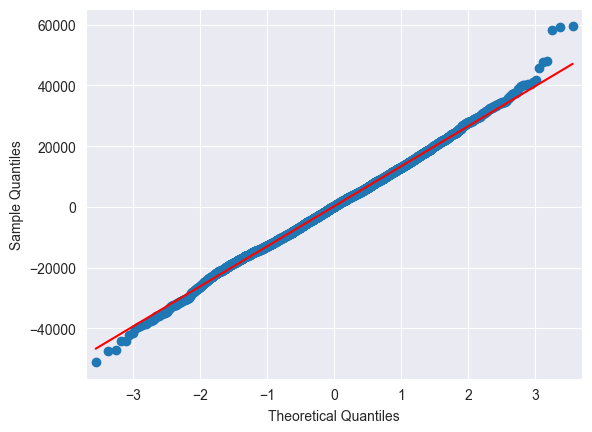

In [12]:
sm.qqplot(df_pred_prophet2['residuals'], line='s')
plt.show()

## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


In [ ]:
# Evaluate the model using your chosen metrics
# Example for classification
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))

# Example for regression
# mse = mean_squared_error(y_test, y_pred)

# Your evaluation code here


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [ ]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")
